<h1><center>HW 3: Semantic Networks of Social Media Data</center></h1>

Name: Sharan Vivek Chunamari

CWID: 20100962

In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import re
import numpy as np
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import tweepy
import datetime
import time
import csv
from sklearn.feature_extraction.text import CountVectorizer


## Q1 scrape tweets
 * Define a functionn to scrape the most recent tweets from multiple accouts.
 * For each tweet, grab `id`,`created_at`,`full_text`,`user.screen_name`.
 * If it's a retweet, grab full text from the original tweet. (Hint, you can use Try Except to speed up)
 * Make a dataframe and return the dataframe.
 * Use the function to get the original tweets published by a list of accounts. 


In [5]:
def get_all_tweets(user_names, keyword=None):
    
    # Authenticate to Twitter
    auth=tweepy.OAuthHandler("0IXP7IrwVlSn7EloGVxNM2vza","hi4JK35UDMWCWzeM2ygcVg4ewz5pc6EU2P8BaICPgub5sJ50Nj")
    auth.set_access_token("1486754611469901828-z04Vt93xk6PXESbxHnEWVIC23VxlLg","lQn3yDa8IT3p1fl2mcqf34rirn1gtfyJwRl1H12a90jDY")

    # Create API object
    api = tweepy.API(auth, wait_on_rate_limit=True, wait_on_rate_limit_notify=True)

    tweets_data = []
    for account in user_names:
        max_id = None 
        while True:
            try:
                tweets = api.user_timeline(screen_name=account, count=200, tweet_mode='extended', max_id=max_id)

                if not tweets:
                    break

                tweets_data += [{'0': tweet.id,
                                 '1': tweet.created_at,
                                 '2': tweet.user.screen_name,
                                 '3': tweet.retweeted_status.full_text if hasattr(tweet, 'retweeted_status') else tweet.full_text
                                } for tweet in tweets]
                
                max_id = tweets[-1].id - 1
            except tweepy.TweepError as e:
                print(f"Error {account}: {e}")
                break

    df = pd.DataFrame(tweets_data)
    return df


In [6]:
# we use some examples of news outlets in this study: 
# https://www.researchgate.net/profile/Matthew-Miles-2/publication/357193810_Does_the_Ideology_of_the_Newsroom_Affect_the_Provision_of_Media_Slant/links/62ea8ddf88b83e7320a67270/Does-the-Ideology-of-the-Newsroom-Affect-the-Provision-of-Media-Slant.pdf
# use your function to scrape the tweets for the following accounts and compile a corpus

media1=['foxnews','dcexaminer','breitbartnews']
media1_corpus=get_all_tweets(media1)
media1_corpus

TypeError: __init__() got an unexpected keyword argument 'wait_on_rate_limit_notify'

In [13]:
# use your function to scrape the tweets for the following accounts and compile another corpus

media2=['cnn','nytimes','msnbc']
media2_corpus=get_all_tweets(media2)
media2_corpus

0                   1      2  \
0     1633558314729754626 2023-03-08 20:00:26    CNN   
1     1633554464606126080 2023-03-08 19:45:08    CNN   
2     1633550703464701952 2023-03-08 19:30:12    CNN   
3     1633546915605544960 2023-03-08 19:15:09    CNN   
4     1633543155294547968 2023-03-08 19:00:12    CNN   
...                   ...                 ...    ...   
9745  1611603074048483328 2023-01-07 05:58:09  MSNBC   
9746  1611599550086529025 2023-01-07 05:44:09  MSNBC   
9747  1611598535786471424 2023-01-07 05:40:07  MSNBC   
9748  1611597413109596160 2023-01-07 05:35:39  MSNBC   
9749  1611596270640025602 2023-01-07 05:31:07  MSNBC   

                                                      3  
0     Key congressional Democrats have asked the for...  
1     The Grizzlies lost their second straight game ...  
2     The White House’s endorsement of a bill that w...  
3     She created a relationship with a chatbot. 11 ...  
4     CNN medical analyst Dr. Leana Wen answers ques...  
...                                                 ...  
9745  NEW: President Biden congratulates Kevin McCar...  
9746  LIVE on @MSNBC: \n\nRepublican Rep. Kevin McCa...  
9747  BREAKING: Kevin McCarthy is elected House spea...  
9748  Steve Kornacki: "McCarthy is going to win the ...  
9749  BREAKING: Kevin McCarthy elected House speaker...  

[9750 rows x 4 columns]

## Q2 Build semantic networks
* Get a subset of tweets that contain the keyword "ChatGPT" for the two sets of documents, ignore case
* First clean the tweets to remove accounts and links
* Define a function to build a semantic network for each set of cleaned documents, return that network 
    - only use words that have at least appeared in two documents
    - remove stop words
    - only get the top 50 features
    - use the cooccurrence matrix (dichotomize the matrix so that values larger than 1 will be set as 1) to build the semantic network
    - make node size proportional to the **eigenvector centrality** of words

In [14]:
# get a subset of tweets
def get_chatgpt_tweets(media_corpus):
    chatgpt_tweets = media_corpus[media_corpus['3'].str.lower().str.contains('chatgpt')]
    return chatgpt_tweets

df1 = get_chatgpt_tweets(media1_corpus)
df2 = get_chatgpt_tweets(media2_corpus)


In [15]:
def clean_tweet(x):
    # remove accounts
    x = re.sub(r'@\w+', '', x)

    # remove links
    x = re.sub(r'http\S+', '', x)
    x = re.sub(r'www\S+', '', x)

    return x
    

In [16]:
# clean the tweets
df1["cleaned_tweet"]=df1.iloc[:,3].apply(clean_tweet)
df2["cleaned_tweet"]=df2.iloc[:,3].apply(clean_tweet)

<ipython-input-16-2d2576e9f1ed>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1["cleaned_tweet"]=df1.iloc[:,3].apply(clean_tweet)
<ipython-input-16-2d2576e9f1ed>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2["cleaned_tweet"]=df2.iloc[:,3].apply(clean_tweet)


In [17]:
import nltk
nltk.download("stopwords")
from nltk.corpus import stopwords
from collections import Counter


def build_semantic_network(doc_set):
    all_words = [word for doc in doc_set for word in doc.split()]
    unique_words = [word for word in Counter(all_words).keys() if Counter(all_words)[word] >= 2]
    unique_word_reader = [word for word in unique_words if word not in stopwords.words('english')]

    top_words = [word for word, count in Counter(all_words).most_common() if word in unique_word_reader][:50]

    matrix = np.zeros((50, 50))
    
    for doc in doc_set:
        word_1 = [word for word in doc.split() if word in top_words]
        for i, word1 in enumerate(word_1):
            for j, word2 in enumerate(word_1[i+1:]):
                if word1 != word2:
                    matrix[top_words.index(word1), top_words.index(word2)] += 1
                    matrix[top_words.index(word2), top_words.index(word1)] += 1

    matrix[matrix > 1] = 1

    network = nx.Graph()
    for i, word in enumerate(top_words):
        network.add_node(word, size=0)
    for i in range(50):
        for j in range(i+1, 50):
            if matrix[i,j] > 0:
                network.add_edge(top_words[i], top_words[j], weight_value=matrix[i,j])

    centrality = nx.eigenvector_centrality_numpy(network)
    for word, size in centrality.items():
        network.nodes[word]['size'] = size

    pos = nx.spring_layout(network, seed=42)
    plt.figure(figsize=(50, 50))
    node_size = [size*5000 for size in nx.get_node_attributes(network, 'size').values()]
    edge_width = [weight/max([network[u][v]['weight_value'] for u,v in network.edges()])*2 for weight in [network[u][v]['weight_value'] for u,v in network.edges()]]
    nx.draw(network, pos=pos, node_size=node_size, with_labels=True, font_size=50)
    nx.draw_networkx_labels(network, pos=pos, font_size=50)
    nx.draw_networkx_edges(network, pos=pos, width=edge_width)

    plt.show()

    return network


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

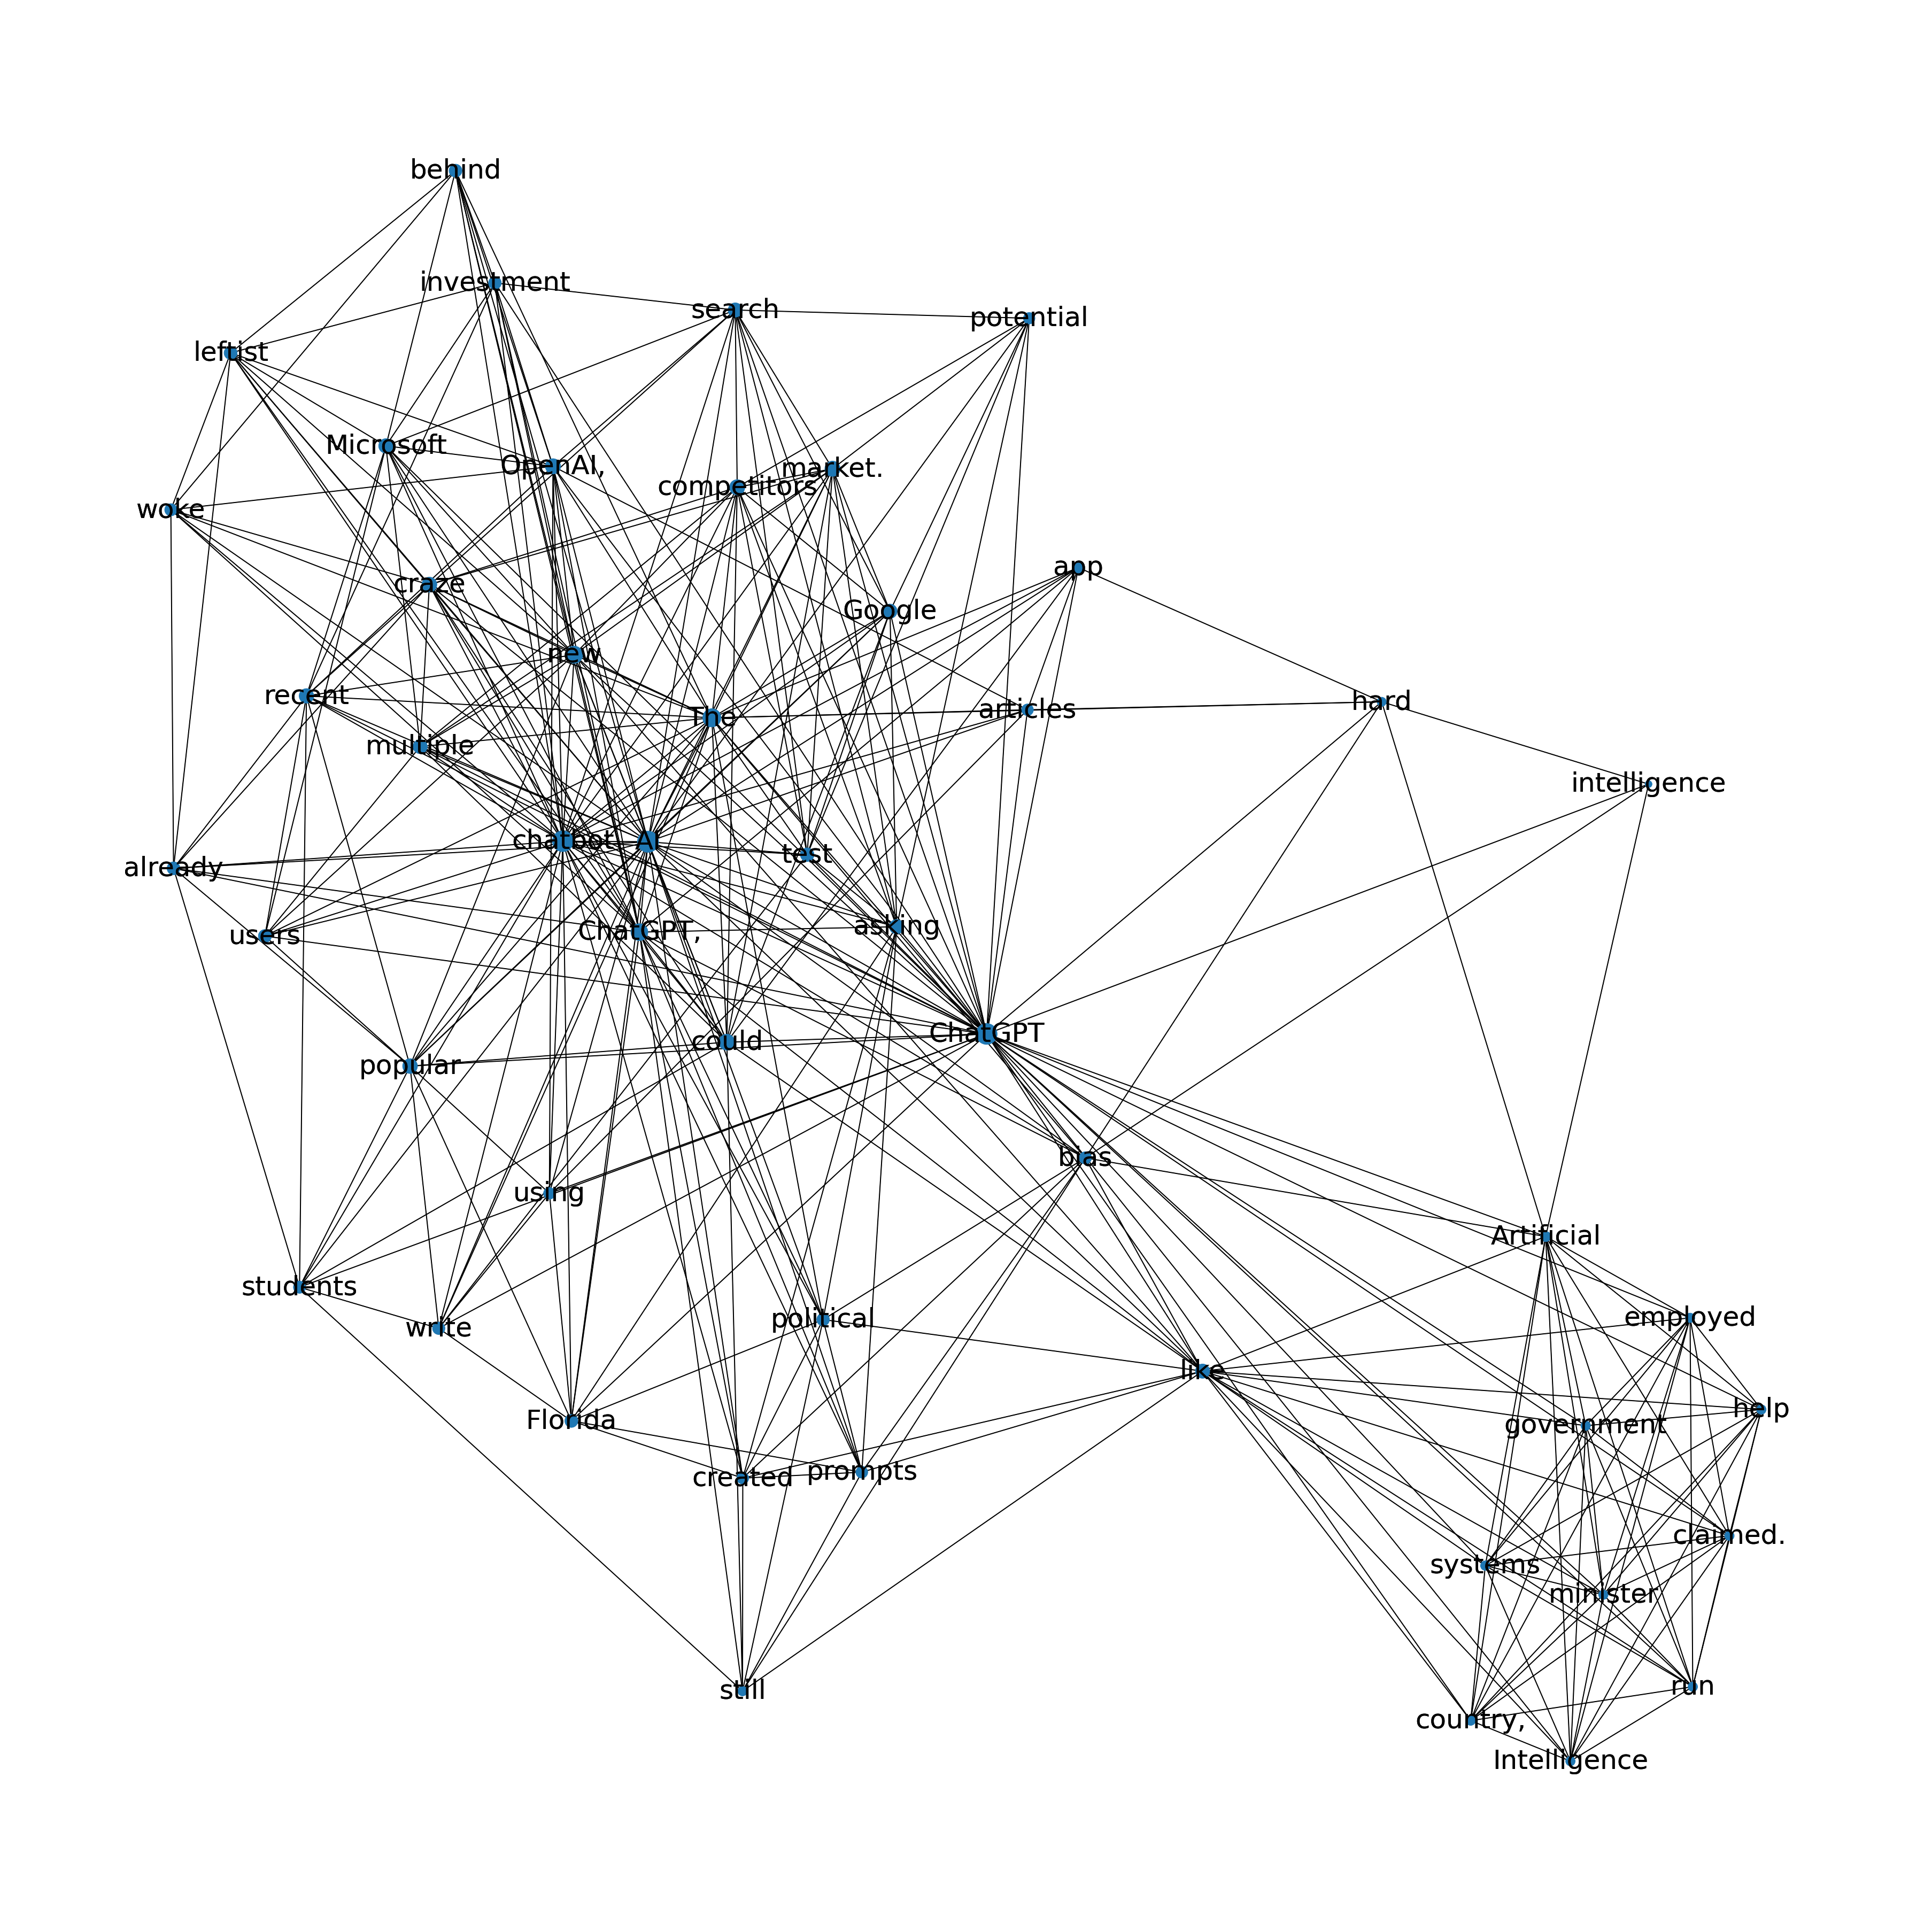

In [18]:
# use your function for the first corpus
build_semantic_network(set(df1["cleaned_tweet"]))

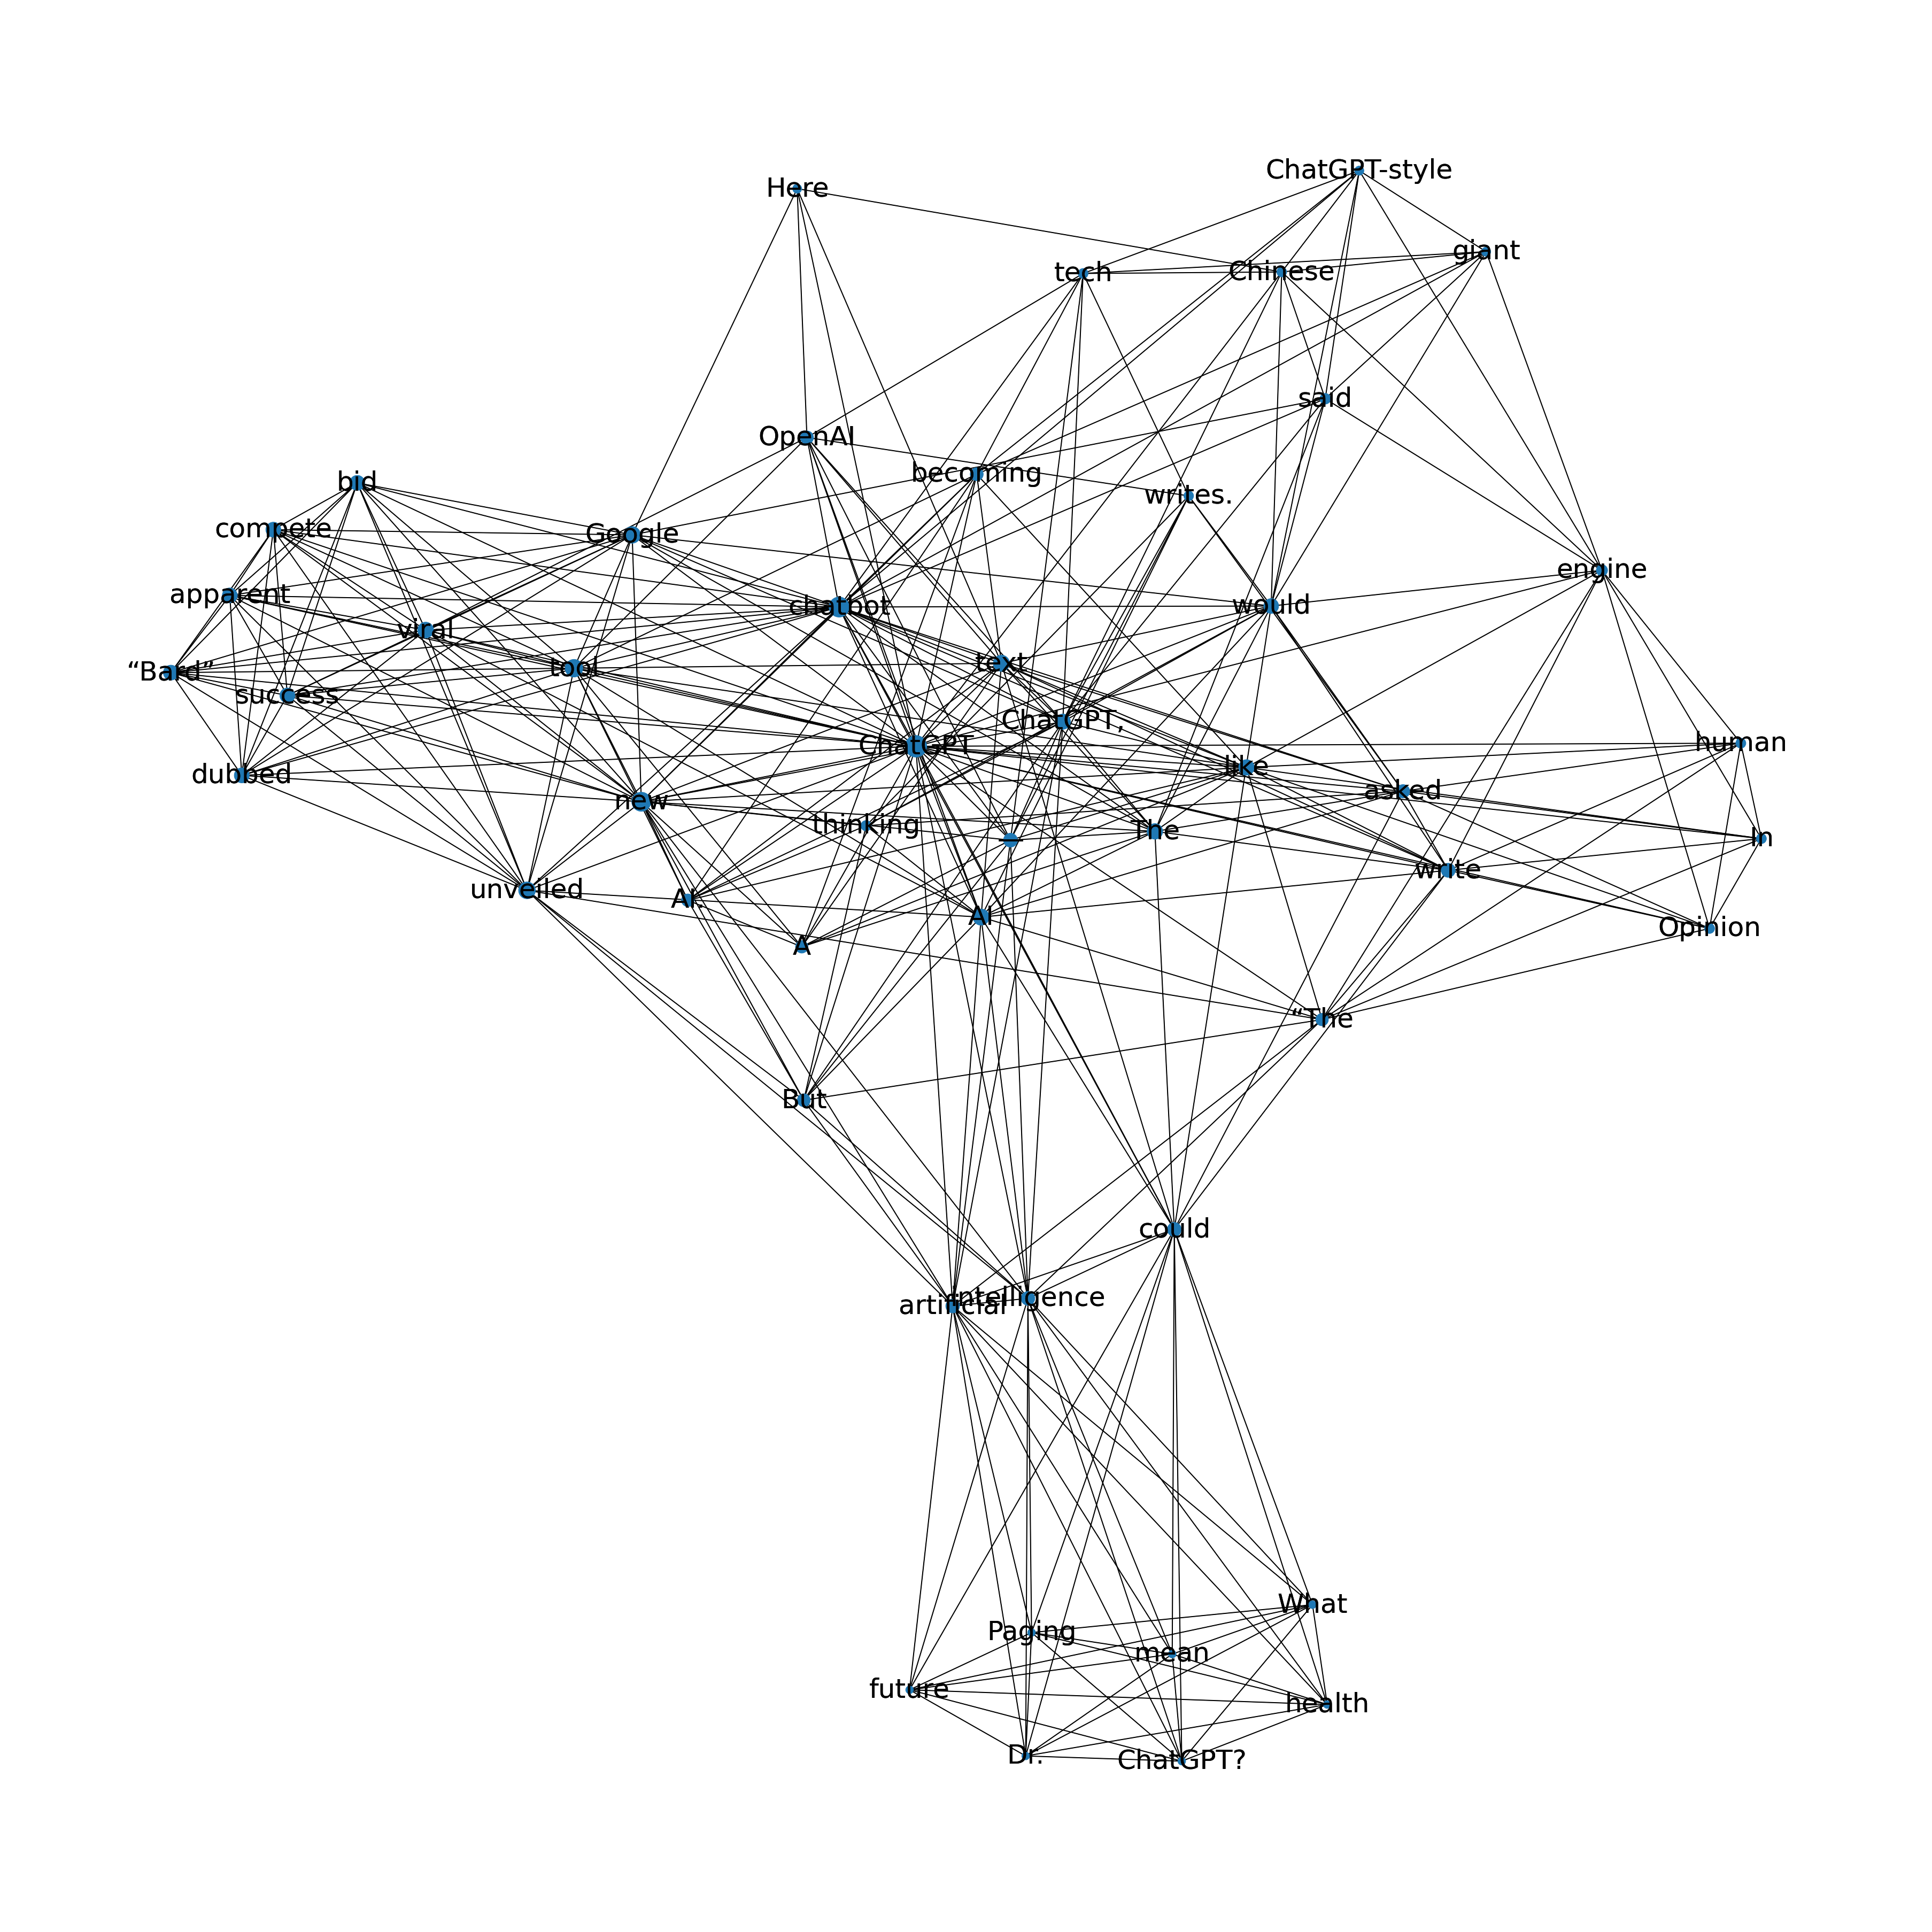

In [19]:
# use your function for the second corpus
build_semantic_network(set(df2["cleaned_tweet"]))

## Q3 Analyze networks
* Based on your visualization, and the calculation of words' eigenvector centrality, briefly explain your observations


The semantic network is constructed based on the frequency of words in the given set of texts. The visual representation of the network shows that some clusters of nodes are more interconnected than others, implying a stronger association between those words. The eigen vector centrality of each word in the network indicates its significance, and in both graphs, "chatgpt" has the highest eigen central value.